<a href="https://colab.research.google.com/github/LuigiPagani/DL-ROM-for-Navier-Stokes-/blob/main/NAML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Library Installation

import numpy as np
import matplotlib.pyplot as plt
try:
     import dlroms.fespaces as fe
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     import dlroms.fespaces as fe

In [2]:
#@title Finite Element Solver
from fenics import *
from mshr import *
import numpy as np
from IPython.display import clear_output as clc
from dlroms import num2p
import dlroms.fespaces as fe
import gdown

gdown.download(id='1SLZQIK7tHzSLWYuQMPY4Yx1UGb83XpzK', output='cylinder.xml', quiet=False)

# Time discretization
T = 3.5
num_steps = int(1000*T)
dt = T / num_steps


# Load mesh and define function spaces
mesh = fe.loadmesh("cylinder.xml")
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)
Vm = fe.space(mesh, 'CG', 2)

# Problem data
inflow   = 'near(x[0], 0)'
outflow  = 'near(x[0], 2.2)'
walls    = 'near(x[1], 0) || near(x[1], 0.41)'
cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'

inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
bcp = [bcp_outflow]

clc()

def FOMsolver(mu, rho, verbose = True):
    # Trial and test functions
    u = TrialFunction(V)
    v = TestFunction(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)

    # Define functions for solutions at previous and current time steps
    u_n = Function(V)
    u_  = Function(V)
    p_n = Function(Q)
    p_  = Function(Q)

    # Define expressions used in variational forms
    U  = 0.5*(u_n + u)
    n  = FacetNormal(mesh)
    f  = Constant((0, 0))
    k  = Constant(dt)
    mu = Constant(mu)
    rho = Constant(rho)

    # Define symmetric gradient
    def epsilon(u):
        return sym(nabla_grad(u))

    # Define stress tensor
    def sigma(u, p):
        return 2*mu*epsilon(u) - p*Identity(len(u))

    # Define variational problem for step 1
    F1 = (  rho*dot((u - u_n) / k, v)*dx
          + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx
          + inner(sigma(U, p_n), epsilon(v))*dx
          + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds
          - dot(f, v)*dx)
    a1 = lhs(F1)
    L1 = rhs(F1)

    # Define variational problem for step 2
    a2 = dot(nabla_grad(p), nabla_grad(q))*dx
    L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

    # Define variational problem for step 3
    a3 = dot(u, v)*dx
    L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

    # Assemble matrices
    A1 = assemble(a1)
    A2 = assemble(a2)
    A3 = assemble(a3)

    # Apply boundary conditions to matrices
    [bc.apply(A1) for bc in bcu]
    [bc.apply(A2) for bc in bcp]

    solution = []

    # Time-stepping
    t = 0
    solution.append(u_.vector()[:]+0.0)
    for n in range(num_steps):
        if(n%10==0 and verbose):
            clc(wait = True)
            print("Progress: %s." % num2p(n/num_steps))
        # Update current time
        t += dt

        # Step 1: Tentative velocity step
        b1 = assemble(L1)
        [bc.apply(b1) for bc in bcu]
        solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg')

        # Step 2: Pressure correction step
        b2 = assemble(L2)
        [bc.apply(b2) for bc in bcp]
        solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')

        # Step 3: Velocity correction step
        b3 = assemble(L3)
        solve(A3, u_.vector(), b3, 'cg', 'sor')


        # Update previous solution
        u_n.assign(u_)
        p_n.assign(p_)
        solution.append(u_.vector()[:]+0.0)
    if(verbose):
        clc()
    sol2 = [solution[i] for i in range(0, num_steps+1, 25)]
    umod = np.linalg.norm(np.stack(sol2).reshape(len(sol2), -1, 2), axis = -1)
    return umod

def visualize(umod):
    fe.animate(umod[::2], Vm, figsize = (8, 2))





In [3]:
#@title Fourier Modes Embedding Utilities
from dlroms.dnns import Weightless
import torch

class Fourier(Weightless):
    def __init__(self, k):
        super(Fourier, self).__init__()
        self.k = k

    def forward(self, x):
        z = [x[:,0], x[:,1], x[:,2]]
        for k in range(self.k):
            z.append((k*x[:,2]).cos())
            z.append((k*x[:,2]).sin())
        return torch.stack(z, axis = 1)


**Note**

The project extensively uses the library and dataset developed by N. Rares Franco at the Polytechnic University of Milan. N. Rares Franco also provided the Navier Stokes training dataset. This was particularly helpful, as generating an equivalent amount of data would have taken approximately 6 hours on a single Google Colab instance. The dataset is imported using the gdown library. While, the dataset for the advection-diffusion equation was generated using the FEniCS library. It was based on a 30x30 unit square mesh, where the domain Ω is defined as $(0,1) \times
 (0,1)$.

# **DL-ROM**

Deep learning-based reduced order models (DL-ROMs) are fully data-driven approaches designed to approximate the solution of parameterized partial differential equations (PDEs) using deep learning architectures. In this context, we will focus on a specific type of DL-ROM that utilizes autoencoders to reduce the dimensionality of the problem and learn the parameter-to-solution map efficiently.

Given a parameter space $\Theta \subset \mathbb{R}^p$ associated with a parameterized PDE and a high-fidelity space $\mathbb{R}^{N_h}$, we aim to find a reduced order representation with a latent dimension $n \ll N_h$. To achieve this, we define three neural networks:

$$\Psi': \mathbb{R}^{N_h} \to \mathbb{R}^{n},$$
$$\Psi: \mathbb{R}^{n} \to \mathbb{R}^{N_h},$$
$$\phi: \mathbb{R}^{p} \to \mathbb{R}^{n},$$

where $\Psi'$ is the encoder, \(\Psi\) is the decoder, and \(\phi\) is the parameter-to-latent space map.

The networks are trained to satisfy the following conditions:

$$\mathbf{u}_{\boldsymbol{\mu}} \approx \Psi(\Psi'(\mathbf{u}_{\boldsymbol{\mu}})), \quad \text{and} \quad \phi(\boldsymbol{\mu}) \approx \Psi'(\mathbf{u}_{\boldsymbol{\mu}}),$$

where $\mathbf{u}_{\boldsymbol{\mu}}$ is the high-fidelity solution corresponding to the parameter $\boldsymbol{\mu} \in \Theta$.

The training process involves two main phases:

1. **Autoencoder Training**: Train the autoencoder, composed of the encoder $\Psi'$ and the decoder $\Psi$, to minimize the reconstruction error of the high-fidelity solutions. This step ensures that the autoencoder can effectively compress and reconstruct the high-fidelity data.

2. **Latent Space Mapping Training**: Freeze the encoder and decoder networks. Train the parameter-to-latent space map $\phi$ to minimize the error in mapping the parameters to the corresponding latent representations obtained from the encoder.

After these two training phases, the final model is expressed as:

$$\mathbf{u}_{\boldsymbol{\mu}} \approx \Psi(\phi(\boldsymbol{\mu})).$$

In the case of time-dependent problems, the parameter vector is extended to include the time variable $t$. That is, $\boldsymbol{\mu} = [\tilde{\boldsymbol{\mu}}, t]$, where $\tilde{\boldsymbol{\mu}}$ represents the PDE parameters and \(t\) is treated as an additional parameter.

This approach leverages the power of deep learning to create efficient reduced order models that can accurately predict high-fidelity solutions for given parameters, significantly reducing the computational cost compared to traditional methods.

## Example
We are modelin the Navier-Stokes equations:

$$
\begin{cases}
\rho\left(\displaystyle \frac{\partial \boldsymbol{v}}{\partial t} + \boldsymbol{v}\cdot\nabla\boldsymbol{v}\right)-\epsilon\Delta \boldsymbol{v} + \nabla q = 0 & \text{in}\;\Omega\times(0,T],\\\\
\nabla\cdot\boldsymbol{v}= 0 & \text{in}\;\Omega\times(0, T],\\\\
\boldsymbol{v} = \boldsymbol{g} & \text{on}\;\Gamma_{\text{in}}\times(0, T]\;\cup\;\Omega\times\{0\},\\\\
\boldsymbol{v} = 0 & \text{on}\;\partial\Omega\setminus\left(\Gamma_{\text{in}}\cup\Gamma_{\text{out}}\right)\times(0, T],\\\\
q = 0 & \text{on}\;\Gamma_{\text{out}}\times(0, T]\end{cases}
$$

Here, $\epsilon>0$ is the dynamic viscosity and $\rho>0$ is the fluid density, whereas $\boldsymbol{v}:\Omega\times[0,T]\to\mathbb{R}^{2}$ is the fluid velocity field. For the sake of simplicity, we shall focus on the scalar field

$$u:=|\boldsymbol{v}|$$

describing the velocity magnitude across $\Omega$, where $|\cdot|$ is the Euclidean norm.
</br>
</br>
The training data is composed of pairs of parameters-solutions, where the parameters are$\epsilon$ and $\rho$, and the solution-trajectory is $u$.In particular The solution is approximated using a P2 discretization in space. Only $N_t=141$ equispaced timesteps in $[0,T]=[0, 3.5]$ are returned. We train on random dataset with $\log_{10}\epsilon\in[-3.5,\;-2.5]$ and $\rho\in[0.5,\;1]$ of 41 simulations.

In [4]:
# Downloading the dataset
from IPython.display import clear_output
import numpy as np
import gdown
gdown.download(id = "1Sj7sMVgrOv5dM4wYbiGCyDktFpdk8VGR", output = "nstokes_data.npz", quiet=False)
clear_output()

In [52]:
data = np.load("nstokes_data.npz")
mu, u = data['mu'], data['u']
mu.shape,u.shape


((41, 2), (41, 141, 6477))

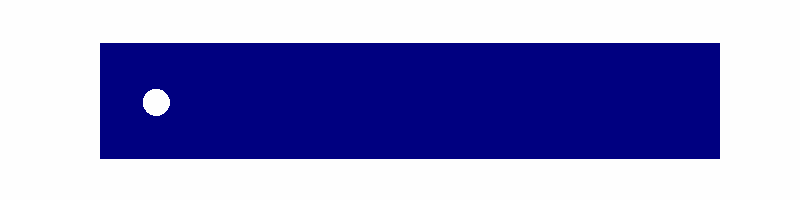

In [6]:
visualize(u[0])

In [53]:
from dlroms import*
mu, u = dv.tensor(data['mu']), dv.tensor(data['u'])

ndata, ntimes, nh = u.shape
p = mu.shape[-1]
print("Trajectories:\t%d." % ndata)
print("Timesteps:\t%d." % ntimes)
print("FOM dimension:\t%d." % nh)
print("Parameters:\t%d." % p)


mut = dv.zeros(ndata, ntimes, p+1)
times = dv.tensor(np.linspace(0, 3.5, ntimes))
for i in range(ndata):
    mut[i,:,:2] = mu[i]
    mut[i,:, 2] = times

Trajectories:	41.
Timesteps:	141.
FOM dimension:	6477.
Parameters:	2.


In [54]:
u = u.reshape(-1, nh)
mut = mut.reshape(-1, p+1)

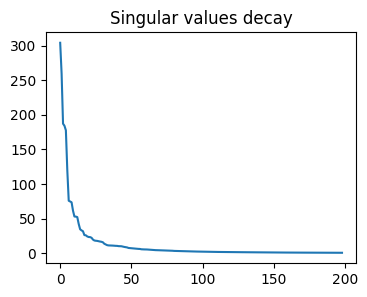

In [9]:
from scipy.linalg import svd
import matplotlib.pyplot as plt
ntrain = 25*ntimes


_, s, _ = svd(u[:ntrain].T.cpu().numpy(), full_matrices = True)
plt.figure(figsize = (4, 3))
plt.plot(s[1:200])
plt.title("Singular values decay")
plt.show()



**Need for Autoencoders**

The Navier-Stokes Equation is a non-linear Partial Differential Equation, so there is a need for using non-linear reduction techniques. If we had used POD-Galerkin, the singular-values decay would have required us to use 100 bases in the reduced model. However, a theorem by Professor Manzoni, Zunino, and Rares assures us that with an autoencoder, a latent dimension of 7 is sufficient.

Moreover, with POD-Galerkin, we would have had to use a time-stepping method in the latent space, which for non-linear problems is not trivial. With the autoencoder technique, we can instead treat time as a parameter and query our neural network at each time step independently from the others.

One drawback is that we cannot enforce the continuity of the solution in time, and we may have unphysical results if our neural network is not well-trained.

#### Theorem 3 (Franco, M., Zunino 2023)

Assume the parameter space is compact and the parameter-to-solution map is Lipschitz continuous. Additionally, assume that $\Psi$ and $\Psi'$ are s-times differentiable, $s \geq 2$, and have bounded derivatives. Then for any $\epsilon > 0$ there exists a DL-ROM such that

- $\Psi$ has $ C m^{1+n/(s-1)} \varepsilon^{-n/(s-1)} \log(m/\varepsilon) $ active weights and \( C \log(m/\varepsilon) \) layers,
- $\varphi$ has $ C \varepsilon^{-p} \log(1/\varepsilon) $ active weights and $ C \log(1/\varepsilon) $ layers,

and $ \mathcal{E}_A < 2\varepsilon $ where $ m := \min\{m \mid d_m(S) < \varepsilon\} $


Sinc here we have 2 parameters and time is treated as an additional parameter, we choose 2*(2+1)+1 = 7 latent dimension.


In the training it is important to use the $L^2$ error instead of the classical MSE since we are not dealing with a regular mesh, in some part of the domain points are denser nd in other coarser, thus the classical MSE is not a suitabe measure of the error in this case. Obviously, the use of the $L^2$ norm makes training more expensive, since during error calculation it is required to perform numerical integration.The network with 50 epochs is undertrained. It would benefit of more epochs, however I have been having problem with GPUs on Colab and so due to time constraints I had to use CPU.

In [10]:
import torch
import numpy as np
import random
import os

def set_seed(seed: int = 42):
    """
    Set seed for reproducibility.

    Args:
        seed (int): Seed to use for random number generators. Default is 42.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



In [11]:
l2 = L2(Vm)
l2.cuda()
def error(utrue, upred):
    return (l2(utrue-upred).reshape(-1, ntimes).sum(axis = -1)/l2(utrue).reshape(-1, ntimes).sum(axis = -1)).mean()

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ade15b856e70b5f15224e3f957ccc4e3dad1172b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG2(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0517824 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_899f792bca9deb3c3f12f5cb62d42f0545d411ea

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00285864 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0156677 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_79dd4099c4e669212673d783637297ee756e6a33

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00281477 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0203671 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_6374535ba84ea32d2351d1e531a3a93b7a39dbac

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00247836 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0186479 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_66170f427fb7c9d9caadb39d728b0be317507df5

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00427079 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0111213 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

In [12]:
latent = 7
encoder = Dense(nh, 60) + Dense(60, latent)
decoder = Dense(latent, 50) + Dense(50, 100) + Dense(100, nh, activation=None)
autoencoder = DFNN(encoder + decoder)
autoencoder.He()



autoencoder.moveOn(dv)
set_seed(13) #So we can enjoy an unlucky training run ;)
autoencoder.train(u, u, ntrain = ntrain, epochs = 1250, loss = mse(l2))
autoencoder.eval()  # Set the model to evaluation mode
autoencoder.freeze()


		Train		Test
Epoch 1250:	2.18e-04	3.15e-04.

>> ETA: 0.31s.

Training complete. Elapsed time: 6 minutes 27.15 seconds.


The training of the autoencoder required 25 minutes of time on a single T4 GPU available for free on Google Colab.

In [66]:
num2p(error(u[ntrain:], autoencoder(u[ntrain:])))

'1.43%'

**Fourier Modes Embedding**

Fourier modes are used to capture periodic components in the data. By representing functions as a sum of sine and cosine terms, Fourier modes provide an efficient way to encode oscillatory patterns, which are common in solutions of PDEs like the Navier-Stokes equations. The Fourier transformation is applied to the input parameters, enhancing the neural network's ability to learn complex mappings.

In [65]:
from dlroms import*

nu = encoder(u)
nu_mean, nu_std = nu[:ntrain].mean(axis = 0), nu[:ntrain].var(axis = 0).sqrt()
nu = (nu - nu_mean)/nu_std
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nu = nu.to(device)


fmodes = 15
phi = DFNN(Fourier(fmodes) + Dense(p+1+2*fmodes, 750) + Dense(750, latent, activation = None))

phi.He()
phi.moveOn(dv)
set_seed(17) #Here we go again, another unlucky run
phi.train(mut, nu, ntrain = ntrain, epochs = 2000, loss = mse(euclidean))
phi.freeze()

		Train		Test
Epoch 2000:	3.78e-03	9.52e-03.

>> ETA: 0.29s.

Training complete. Elapsed time: 9 minutes 42.29 seconds.


The training of this FFNN required 20 minutes on a  T4 GPU provided for free on Google Colab

In [67]:
dlrom = lambda mt: decoder(phi(mt)*nu_std + nu_mean)
num2p(error(u[ntrain:], dlrom(mut[ntrain:])))

'1.67%'

In [16]:
error(u[ntrain:], dlrom(mut[ntrain:]))

tensor(0.0167, device='cuda:0')

In [69]:
def error(utrue, upred):
    return (l2(utrue-upred).reshape(-1, ntimes).sum(axis = -1)/l2(utrue).reshape(-1, ntimes).sum(axis = -1)).mean()
#Function to calulate error per time step

error_per_timestep = l2((u[ntrain:]- dlrom(mut[ntrain:]))).reshape(-1,ntimes)

**Plotting a FOM Solution over time-steps 1-70-140**


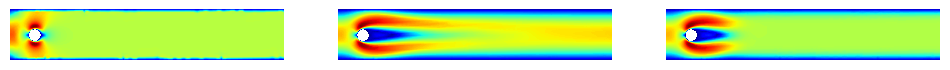

In [18]:
fe.multiplot(u[[141*20+1,141*20+ 70, 141*20+14]], (1, 3), Vm)

**Plotting the respective DL-ROM Solution over time-steps 1-70-140**


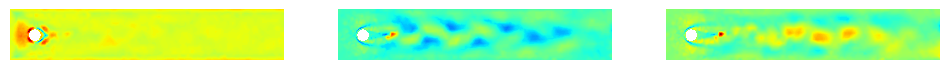

In [19]:
fe.multiplot((dlrom(mut)-u)[[141*20+1,141*20+ 70, 141*20+140]], (1, 3), Vm)

**Plotting the Error at the final time step**

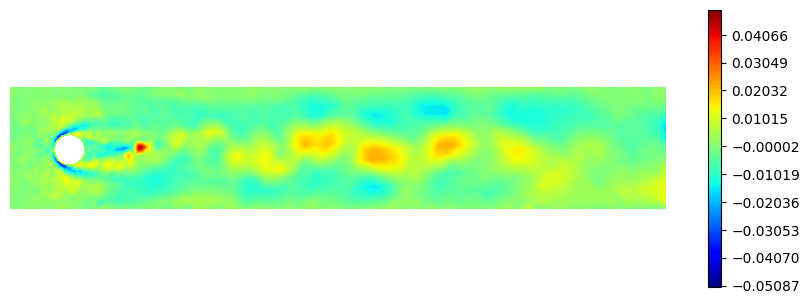

In [20]:
import matplotlib.pyplot as plt
fe.multiplot((dlrom(mut)-u)[[ 141*20+140]], (1,3),Vm, colorbar=True, shrink=0.3,size = 12)



**Plotting Average Error on test data for each time step**

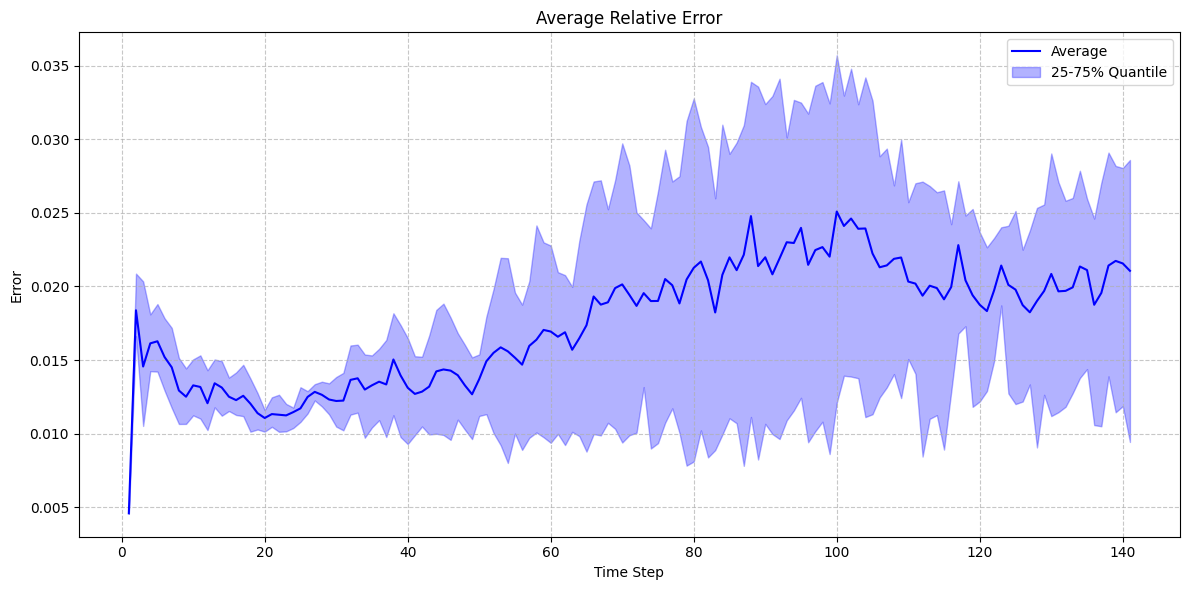

<Figure size 640x480 with 0 Axes>

In [70]:
import torch
import numpy as np
import matplotlib.pyplot as plt


# Move tensor to CPU and convert to numpy
error_per_timestep_cpu = error_per_timestep.cpu().numpy()

# Calculate average and quantiles
average = np.mean(error_per_timestep_cpu, axis=0)
q25 = np.percentile(error_per_timestep_cpu, 25, axis=0)
q75 = np.percentile(error_per_timestep_cpu, 75, axis=0)

# Create the plot
plt.figure(figsize=(12, 6))
time_steps = range(1, 142)

plt.plot(time_steps, average, label='Average', color='blue')
plt.fill_between(time_steps, q25, q75, alpha=0.3, color='blue', label='25-75% Quantile')

plt.xlabel('Time Step')
plt.ylabel('Error')
plt.title('Average Relative Error')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# If you want to save the plot instead of showing it:
plt.savefig('error_plot.png', dpi=300, bbox_inches='tight')

**Training of a second DL-ROM ith Synthetic Data Generation**

In [71]:
import torch
import numpy as np

# Assuming mu, device, and other necessary variables are already defined

# Your existing code for sampling parameters
mu_min = torch.min(mu, dim=0).values
mu_max = torch.max(mu, dim=0).values

mu_min = mu_min.to(device)
mu_max = mu_max.to(device)

num_columns = mu_min.shape[0]

rand_tensor = torch.rand(100, num_columns, device=device)

sampled_mu = mu_min + (mu_max - mu_min) * rand_tensor

# New code to create trajectories
ntimes = 141  # As per your description
times = torch.tensor(np.linspace(0, 3.5, ntimes), device=device)

# Create sampled_mut with the correct shape
sampled_mut = torch.zeros(100, ntimes, num_columns + 1, device=device)

for i in range(100):
    sampled_mut[i, :, :num_columns] = sampled_mu[i].unsqueeze(0).repeat(ntimes, 1)
    sampled_mut[i, :, num_columns] = times

# Print some information about the resulting tensor
print(f"Number of sampled parameter sets: {sampled_mut.shape[0]}")
print(f"Number of timesteps: {sampled_mut.shape[1]}")
print(f"Total dimensions (parameters + time): {sampled_mut.shape[2]}")

Number of sampled parameter sets: 100
Number of timesteps: 141
Total dimensions (parameters + time): 3


In [72]:
sampled_mut.shape
mut = mut.reshape(41, 141,p+1)
sampled_mut.shape,mut.shape
new_data = torch.cat((sampled_mut,mut), dim=0)
new_data = new_data.reshape(-1, p+1)
new_traj = dlrom(new_data)
new_traj.shape


torch.Size([19881, 6477])

In [76]:
new_traj.shape,ntrain

(torch.Size([19881, 6477]), 17625)

In [77]:
latent = 7
encoder1 = Dense(nh, 60) + Dense(60, latent)
decoder1 = Dense(latent, 50) + Dense(50, 100) + Dense(100, nh, activation=None)
autoencoder1 = DFNN(encoder1 + decoder1)
autoencoder1.He()

ntrain = (100+25)*ntimes

autoencoder1.moveOn(dv)
set_seed(13) #So we can enjoy an unlucky training run ;)
autoencoder1.train(new_traj, new_traj, ntrain = ntrain, epochs = 1250, loss = mse(l2))
autoencoder1.eval()  # Set the model to evaluation mode
autoencoder1.freeze()


		Train		Test
Epoch 1250:	3.07e-04	2.79e-04.

>> ETA: 0.77s.

Training complete. Elapsed time: 16 minutes 2.91 seconds.


In [78]:
ntrain = 25*ntimes

num2p(error(u[ntrain:], autoencoder1(u[ntrain:])))

'2.14%'

In [94]:
dlrom = lambda mt: decoder(phi(mt)*nu_std + nu_mean)
ntrain = 25*ntimes
num2p(error(u[ntrain:], dlrom(mut[ntrain:])))

'1.67%'

# Effectiveness of Synthetic Data in Autoencoder Training

Our analysis reveals an unexpected outcome: the inclusion of synthetic data actually reduces the precision of the autoencoder training. This finding is surprising for two reasons:

1. The autoencoder is a neural network designed to learn the identity function, which should theoretically be easier with more data.
2. Despite the synthetic data's obvious deviation from the true data distribution (with a relative error of 1.67%), we anticipated it might still enhance overall performance.

However, the results suggest that the potential benefits of additional data are outweighed by its lower quality. In other words, the increase in data quantity does not compensate for the decrease in data quality. This implies that the synthetic data introduces more noise than useful information into the training process, ultimately degrading the autoencoder's performance rather than improving it.

## Potential Oversights and Future Considerations

It's important to note that while our current findings do not support the benefits of synthetic data, we should consider the possibility that some aspects of our approach might have been overlooked or not optimally implemented. At present, we have no concrete evidence supporting the use of synthetic data in this specific context, but further investigation may be warranted.

One potential area for improvement could be the quality of the synthetic data itself. It's possible that a more sophisticated neural network is needed to generate higher-quality synthetic data that more closely mimics the true data distribution. This could potentially reduce the noise introduced into the training process and lead to better results.

However, it's worth noting that our current network for generating synthetic data is already quite complex and computationally expensive to train. This raises questions about the practical feasibility and cost-effectiveness of further increasing the network's complexity.




In [79]:
num2p(error(u[25*ntimes:], autoencoder(u[25*ntimes:])))

'1.43%'

In [80]:
num2p(error(u[25*ntimes:], autoencoder1(u[25*ntimes:])))

'2.14%'

In [85]:
ntrain = 125*ntimes


17625

In [86]:
from dlroms import*

nu1 = encoder1(new_traj)
nu_mean1, nu_std1 = nu1[:ntrain].mean(axis = 0), nu1[:ntrain].var(axis = 0).sqrt()
nu1 = (nu1 - nu_mean1)/nu_std1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nu1 = nu1.to(device)


fmodes = 15
phi1 = DFNN(Fourier(fmodes) + Dense(3+2*fmodes, 750) + Dense(750, latent, activation = None))

phi1.He()
phi1.moveOn(dv)
set_seed(17) #Here we go again, another unlucky run
phi1.train(new_data, nu1, ntrain = ntrain, epochs = 2000, loss = mse(euclidean))
phi1.freeze()

		Train		Test
Epoch 2000:	1.17e-02	1.19e-02.

>> ETA: 0.30s.

Training complete. Elapsed time: 10 minutes 6.97 seconds.


In [92]:
ntrain = 25*ntimes,u.shape
mut = mut.reshape(-1,3)

**Performanc of the entire DL_ROM trianed with synthetic data**
As it can be shown, the synthetic data not only makes the perofrmance of the autoencoder worse, but also the performance of the ensemble of Neural Networks composing the DL-ROM system.

In [96]:
#@title Performance of original DL-ROM
dlrom = lambda mt: decoder(phi(mt)*nu_std + nu_mean)
num2p(error(u[ntrain:], dlrom(mut[ntrain:])))

'1.67%'

In [ ]:
#@title Performance of  DL-ROM trained also on synthetic data
dlrom1 = lambda mt: decoder1(phi1(mt)*nu_std1 + nu_mean1)
num2p(error(u[ntrain:], dlrom1(mut[ntrain:])))

In [ ]:
#@title Computational Cost of DL-ROM Inference
import numpy as np
from time import perf_counter
import torch

# ntimes, p, times, dv, dlrom, visualize

mu0 = np.array([-3.2, 0.9])
mu0t = np.zeros((ntimes, p+1))
mu0t[:, 2] = times.cpu()
mu0t[:, :2] = mu0
mu0t = dv.tensor(mu0t)

num_iterations = 50
total_time = 0

for _ in range(num_iterations):
    t0 = perf_counter()
    uROM = dlrom(mu0t)
    t1 = perf_counter()
    total_time += (t1 - t0)

    # Uncomment the next line if you want to visualize each iteration
    # visualize(uROM)

average_time = total_time / num_iterations
print(f"Average DL-ROM simulation time for a trajectory  over {num_iterations} iterations: {average_time:.3f}s")

Average DL-ROM simulation time for a trajectory  over 50 iterations: 0.001s


The average cost of the FEM solves is in the ballpark of 450s, and in soe occasions it also occurs into convergence problem due to the non linearity of the equation. So with the ROM we are achievieng a computational speedup of $4.3*10^4$ with a relative error of 1.5%.

#**Advection Diffusion Boundary Value Problem**


We consider the following advection-diffusion system governed by the equation:

$$
\begin{cases}
-\Delta u + w_1 b_1 + w_2 b_2 \cdot \nabla u = 0 & \text{in } \Omega \times (0, T) \\
-\nabla u \cdot n = 0 & \text{on } \partial \Omega \times (0, T) \\
u(\cdot, 0) = u_0 & \text{in } \Omega
\end{cases}
$$

This system is particularly relevant in scenarios where the spreading of pollutants needs to be modeled in a fluid environment influenced by mechanical devices like turbines. In this context, the terms $  w_1 $  and $  w_2 $  represent the angular velocities of two turbines, respectively, which modify the fluid dynamics within the domain $  \Omega $ . These velocities are crucial as they significantly influence the trajectory and diffusion of pollutants through convective transport.

The coefficients $  w_1 $  and $  w_2 $ , ranging from $[0, 10^3]$, effectively model the strength of the rotational pull exerted by the turbines. The variables $  b $  and $  p $ , representing the velocity and pressure fields within $  \Omega $ , are governed by Stokes' equations, reflecting how the fluid's momentum and incompressibility are maintained.

Given the configurations of $  w_1 $  and $  w_2 $ , we simulate the dispersion of a pollutant. This model's primary goal is to predict the pollutant's distribution over time, thus aiding in designing effective containment or remediation strategies. The simulation runs until a final time $  T = 0.025 $ , with the computational script \texttt{convdiff.py} using FEniCS to implement the solution to these equations with a discrete timestep $  \Delta t = 5 \cdot 10^{-4} $ . This fine time resolution helps in accurately capturing the dynamics of the pollutant spread, providing insights crucial for environmental engineering applications.

In [ ]:
import gdown

# Download snapshotts.npy
gdown.download(id="1CctZk9gUIUyBVeXjsWE6K7nDBGdm2s7a", output="params.npy", quiet=False)
gdown.download(id="189KMTR6LbsCBpjz8KaRD12JoxqZsaipM", output="snapshots.npy", quiet=False)



Downloading...
From: https://drive.google.com/uc?id=1CctZk9gUIUyBVeXjsWE6K7nDBGdm2s7a
To: /content/params.npy
100%|██████████| 8.13k/8.13k [00:00<00:00, 20.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=189KMTR6LbsCBpjz8KaRD12JoxqZsaipM
From (redirected): https://drive.google.com/uc?id=189KMTR6LbsCBpjz8KaRD12JoxqZsaipM&confirm=t&uuid=e9894eb7-3243-4468-b36e-88c44f6660ab
To: /content/snapshots.npy
100%|██████████| 196M/196M [00:00<00:00, 224MB/s]


'snapshots.npy'

In [ ]:
u = np.load("snapshots.npy")
mu = np.load("params.npy")

In [ ]:
from dlroms import*
mu, u = dv.tensor(mu), dv.tensor(u)
nh = 961
ntimes = 51
ndata = mu.shape[0]
ntrain = ndata*ntimes //2
p = mu.shape[-1]
print("Trajectories:\t%d." % ndata)
print("Timesteps:\t%d." % ntimes)
print("FOM dimension:\t%d." % nh)
print("Parameters:\t%d." % p)


mut = dv.zeros(ndata, ntimes, p+1)
times = dv.tensor(np.linspace(0, 3.5, ntimes))
for i in range(ndata):
    mut[i,:,:2] = mu[i]
    mut[i,:, 2] = times

Trajectories:	500.
Timesteps:	51.
FOM dimension:	961.
Parameters:	2.


In [ ]:
u = u.reshape(-1, nh)
mut = mut.reshape(-1, p+1)

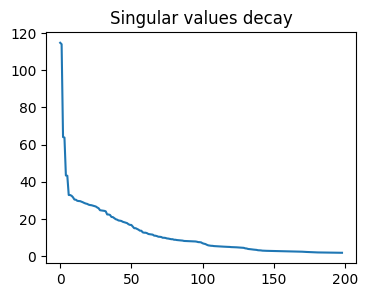

In [ ]:
from scipy.linalg import svd
import matplotlib.pyplot as plt


_, s, _ = svd(u[:ntrain].T.cpu().numpy(), full_matrices = True)
plt.figure(figsize = (4, 3))
plt.plot(s[1:200])
plt.title("Singular values decay")
plt.show()

Unlike the Navier-Stokes problem, this problem is linear. As a result, a standard POD-Galerkin reduced order model with explicit time-stepping would be preferable for several reasons:

1. The model fitting would be computationally less expensive.

2. It would offer comparable performance with a small number of basis functions.

3. It would allow for the enforcement of physical constraints on the reduced model.




In [ ]:
#@title FEM Solver and Snapshots generation
import numpy as np
from fenics import *
from scipy.sparse.linalg import spsolve
import dlroms.fespaces as fe
from scipy.sparse import csr_matrix
import scipy.sparse as sp

mesh = fe.unitsquaremesh(30, 30)
Vh = fe.space(mesh, 'CG', 1)  # FE space for u (chemical concentration)

In [ ]:
l2 = L2(Vh)
l2.cuda()
def error(utrue, upred):
    return (l2(utrue-upred).reshape(-1, ntimes).sum(axis = -1)/l2(utrue).reshape(-1, ntimes).sum(axis = -1)).mean()

**Choice for the dimension of the latent space**

As previously established, when considering time as an additional parameter, we apply the aforementioned theorem to determine the latent space dimension, which in this case is set to 7. For this particular problem, a smaller neural network architecture is being employed, as the underlying physical phenomena are expected to be more readily modeled. This approach is based on the hypothesis that increasing architectural complexity yields diminishing returns in this context. Subsequent experiments and diagnostic analyses have corroborated this supposition, demonstrating that a smaller model structure is sufficient for capturing the relevant dynamics.



In [ ]:
latent = 7
encoder = Dense(nh, 50) + Dense(50, latent)
decoder = Dense(latent, 50) + Dense(50, 100) + Dense(100, nh, activation=None)
autoencoder = DFNN(encoder + decoder)
autoencoder.He()



autoencoder.moveOn(dv)
set_seed(13) #So we can enjoy an unlucky training run ;)
autoencoder.train(u, u, ntrain = ntrain, epochs = 10, loss = mse(l2))
autoencoder.eval()  # Set the model to evaluation mode
autoencoder.freeze()


		Train		Test
Epoch 10:	2.36e-03	2.92e-03.

>> ETA: 0.86s.

Training complete. Elapsed time: 8.32 seconds.


In [ ]:
num2p(error(u[ntrain:], autoencoder(u[ntrain:])))

'21.75%'

In [ ]:
from dlroms import*

nu = encoder(u)
nu_mean, nu_std = nu[:ntrain].mean(axis = 0), nu[:ntrain].var(axis = 0).sqrt()
nu = (nu - nu_mean)/nu_std
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nu = nu.to(device)


fmodes = 10
phi = DFNN(Fourier(fmodes) + Dense(p+1+2*fmodes, 500) + Dense(500, latent, activation = None))

phi.He()
phi.moveOn(dv)
set_seed(17) #Here we go again, another unlucky run
phi.train(mut, nu, ntrain = ntrain, epochs = 10, loss = mse(euclidean))
phi.freeze()

		Train		Test
Epoch 10:	1.82e+01	3.22e+01.

>> ETA: 0.29s.

Training complete. Elapsed time: 2.88 seconds.


In [ ]:
dlrom = lambda mt: decoder(phi(mt)*nu_std + nu_mean)
num2p(error(u[ntrain:], dlrom(mut[ntrain:])))

'103.56%'

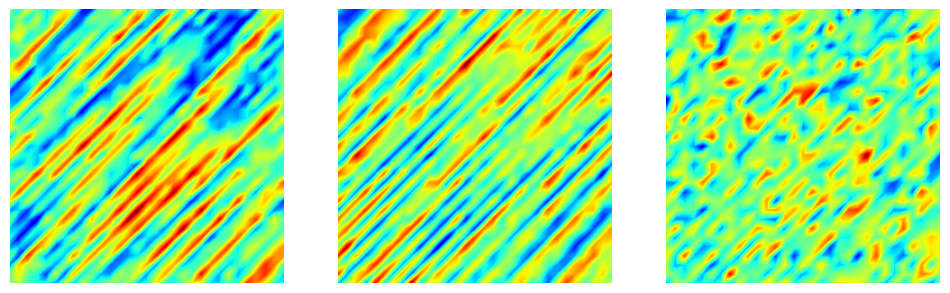

In [ ]:
from time import perf_counter
mu0 = np.array([50, 100])

mu0t = np.zeros((ntimes, p+1))
mu0t[:, 2] = times.cpu()
mu0t[:, :2] = mu0
mu0t = dv.tensor(mu0t)

t0 = perf_counter()
uROM = dlrom(mu0t)
t1 = perf_counter()
fe.multiplot(uROM[[1, 25, 50]], (1, 3), Vh)